In [1]:
import pandas as pd
import numpy as np

In [2]:
print(pd.__version__)
print(np.__version__)

1.4.3
1.21.2


##### points tonotice



- resapling
- shifting
- windowing
- tieshifts

##### Resampling, Shifting, and Windowing

The ability to use dates and times as indices to intuitively organize and access data is
an important piece of the Pandas time series tools. The benefits of indexed data in
general (automatic alignment during operations, intuitive data slicing and access,
etc.) still apply, and Pandas provides several additional time series–specific
operations. <br>

We will take a look at a few of those here, using some stock price data as an example.
Because Pandas was developed largely in a finance context, it includes some very spe‐
cific tools for financial data. For example, the accompanying pandas-datareader
package (installable via conda install pandas-datareader) knows how to import financial data from a number of available sources, including Yahoo finance, Google
Finance, and others. Here we will load Googles’s closing price history:

In [17]:
from pandas_datareader import data

`goog = data.DataReader('GOOG', start='2004', end='2016',
                               data_source='yahoo')
goog.head()`

In [4]:
goog = pd.read_csv('../Data/yahoo/yahho.csv', index_col='Date')
goog.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,2.591785,2.390042,2.490664,2.499133,897427216.0,2.499133
2004-08-20,2.716817,2.503118,2.515820,2.697639,458857488.0,2.697639
2004-08-23,2.826406,2.716070,2.758411,2.724787,366857939.0,2.724787
2004-08-24,2.779581,2.579581,2.770615,2.611960,306396159.0,2.611960
2004-08-25,2.689918,2.587302,2.614201,2.640104,184645512.0,2.640104


In [6]:
goog.index = pd.to_datetime(goog.index)
type(goog.index)

pandas.core.indexes.datetimes.DatetimeIndex

For simplicity, we’ll use just the closing price:

In [7]:
goog = goog['Close']
goog

Date
2004-08-19     2.499133
2004-08-20     2.697639
2004-08-23     2.724787
2004-08-24     2.611960
2004-08-25     2.640104
                ...    
2015-12-24    37.419998
2015-12-28    38.125500
2015-12-29    38.830002
2015-12-30    38.549999
2015-12-31    37.944000
Name: Close, Length: 2863, dtype: float64

We can visualize this using the plot() method, after the normal Matplotlib setup
boilerplate

In [8]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

<AxesSubplot:xlabel='Date'>

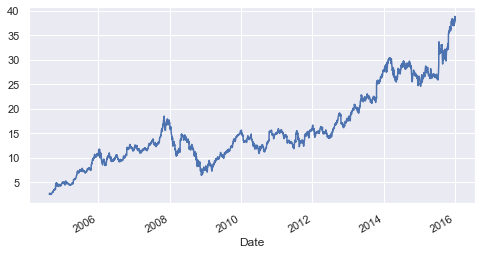

In [9]:
goog.plot(figsize=(8,4))

##### Resampling and converting frequencies

One common need for time series data is resampling at a higher or lower frequency.
You can do this using the resample() method, or the much simpler asfreq() method. The primary difference between the two is that resample() is fundamentally
a data aggregation, while asfreq() is fundamentally a data selection.

Taking a look at the Google closing price, let’s compare what the two return when we
down-sample the data. Here we will resample the data at the end of business year

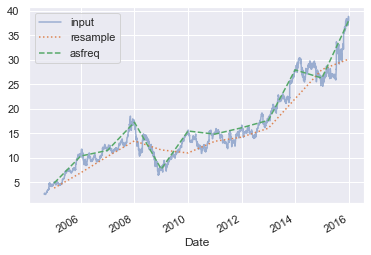

In [10]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],loc='upper left');

Notice the difference: at each point, resample reports the average of the previous year,
while asfreq reports the value at the end of the year.<br>

For up-sampling, resample() and asfreq() are largely equivalent, though resample
has many more options available. In this case, the default for both methods is to leave
the up-sampled points empty—that is, filled with NA values. Just as with the
pd.fillna() function discussed previously, asfreq() accepts a method argument to
specify how values are imputed. Here, we will resample the business day data at a
daily frequency.

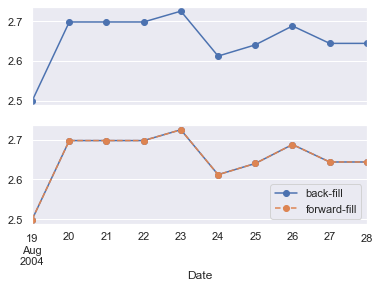

In [26]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]
data.asfreq('D').plot(ax=ax[0], marker='o')
data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

The top panel is the default: non-business days are left as NA values and do not
appear on the plot. The bottom panel shows the differences between two strategies
for filling the gaps: forward-filling and backward-filling.

##### Time-shifts

Another common time series–specific operation is shifting of data in time. Pandas
has two closely related methods for computing this: shift() and tshift(). In short,
the difference between them is that shift() shifts the data, while tshift() shifts the
index. In both cases, the shift is specified in multiples of the frequency.

Here we will both shift() and tshift() by 900 days

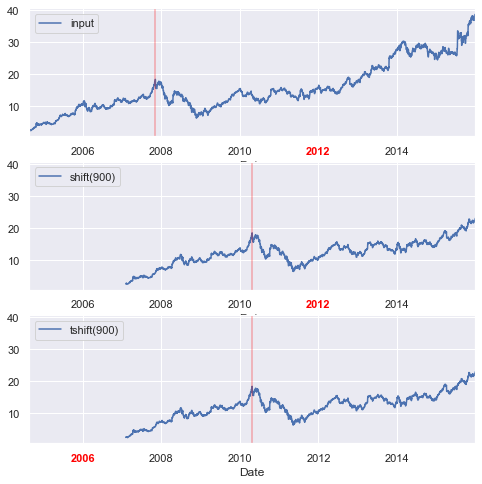

In [20]:
fig, ax = plt.subplots(3, sharey=True, figsize=(8,8))
# apply a frequency to the data
goog = goog.asfreq('D', method='pad')
goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.shift(900).plot(ax=ax[2])
# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')
ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[4].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')
ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[4].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')
ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

We see here that shift(900) shifts the data by 900 days, pushing some of it off the
end of the graph (and leaving NA values at the other end), while tshift(900) shifts
the index values by 900 days. <br>

A common context for this type of shift is computing differences over time. For
example, we use shifted values to compute the one-year return on investment for
Google stock over the course of the dataset.

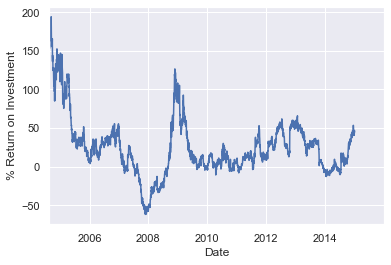

In [17]:
ROI = 100 * (goog.shift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment');

This helps us to see the overall trend in Google stock: thus far, the most profitable
times to invest in Google have been (unsurprisingly, in retrospect) shortly after its
IPO, and in the middle of the 2009 recession.

##### Rolling windows

Rolling statistics are a third type of time series–specific operation implemented by
Pandas. These can be accomplished via the rolling() attribute of Series and Data
Frame objects, which returns a view similar to what we saw with the groupby opera‐
tion. This rolling view makes available
a number of aggregation operations by default.

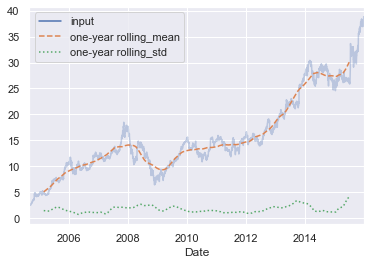

In [22]:
rolling = goog.rolling(365, center=True)
data = pd.DataFrame({'input': goog,
                        'one-year rolling_mean': rolling.mean(),
                        'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

As with groupby operations, the aggregate() and apply() methods can be used for
custom rolling computations.

In [ ]:
goog.resample()